# Salmon

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.3/301.3 kB 1.1 MB/s eta 0:00:00


In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ModSimPy/raw/master/modsim.py')

Downloaded modsim.py


In [3]:
# import functions from modsim

from modsim import *

## Can we predict salmon populations?

Each year the [U.S. Atlantic Salmon Assessment Committee](https://www.nefsc.noaa.gov/USASAC/Reports/USASAC2018-Report-30-2017-Activities.pdf) reports estimates of salmon populations in oceans and rivers in the northeastern United States.  The reports are useful for monitoring changes in these populations, but they generally do not include predictions.

The goal of this case study is to model year-to-year changes in population, evaluate how predictable these changes are, and estimate the probability that a particular population will increase or decrease in the next 10 years.

As an example, I'll use data from page 18 of the 2017 report, which provides population estimates for the Narraguagus and Sheepscot Rivers in Maine.

![USASAC_Report_2017_Page18](https://github.com/AllenDowney/ModSim/raw/main/data/USASAC_Report_2017_Page18.png)

There are tools for extracting data from a PDF document automatically, but for this example I will keep it simple and type it in.

Here are the population estimates for the Narraguagus River:

In [4]:
pops = [2749, 2845, 4247, 1843, 2562, 1774, 1201, 1284, 1287,
        2339, 1177, 962, 1176, 2149, 1404, 969, 1237, 1615, 1201]

To get this data into a Pandas Series, I'll also make a range of years to use as an index.

In [5]:
years = linrange(1997, 2015)
years

array([1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005.,
       2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.,
       2015.])

And here's the series.

In [6]:
pop_series = TimeSeries(pops, index=years)
pop_series

Time
1997.0    2749.0
1998.0    2845.0
1999.0    4247.0
2000.0    1843.0
2001.0    2562.0
2002.0    1774.0
2003.0    1201.0
2004.0    1284.0
2005.0    1287.0
2006.0    2339.0
2007.0    1177.0
2008.0     962.0
2009.0    1176.0
2010.0    2149.0
2011.0    1404.0
2012.0     969.0
2013.0    1237.0
2014.0    1615.0
2015.0    1201.0
Name: Quantity, dtype: float64

Here's what it looks like:

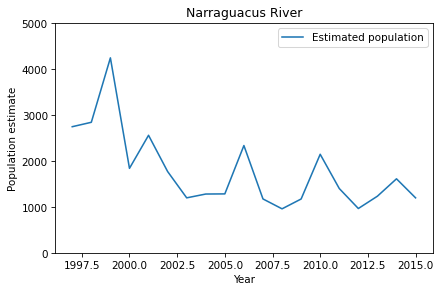

In [7]:
def plot_population(series):
    series.plot(label='Estimated population')
    decorate(xlabel='Year',
             ylabel='Population estimate',
             title='Narraguacus River',
             ylim=[0, 5000])

plot_population(pop_series)

## Modeling changes

To see how the population changes from year-to-year, I'll use `diff` to compute the absolute difference between each year and the next.


In [8]:
abs_diffs = pop_series.diff()
abs_diffs

Time
1997.0       NaN
1998.0      96.0
1999.0    1402.0
2000.0   -2404.0
2001.0     719.0
2002.0    -788.0
2003.0    -573.0
2004.0      83.0
2005.0       3.0
2006.0    1052.0
2007.0   -1162.0
2008.0    -215.0
2009.0     214.0
2010.0     973.0
2011.0    -745.0
2012.0    -435.0
2013.0     268.0
2014.0     378.0
2015.0    -414.0
Name: Quantity, dtype: float64

We can compute relative differences by dividing by the original series elementwise.

In [9]:
rel_diffs = abs_diffs / pop_series
rel_diffs

Time
1997.0         NaN
1998.0    0.033743
1999.0    0.330115
2000.0   -1.304395
2001.0    0.280640
2002.0   -0.444194
2003.0   -0.477102
2004.0    0.064642
2005.0    0.002331
2006.0    0.449765
2007.0   -0.987256
2008.0   -0.223493
2009.0    0.181973
2010.0    0.452769
2011.0   -0.530627
2012.0   -0.448916
2013.0    0.216653
2014.0    0.234056
2015.0   -0.344713
Name: Quantity, dtype: float64

These relative differences are observed annual net growth rates.  So let's drop the `0` and save them.

In [10]:
rates = rel_diffs.dropna()
rates

Time
1998.0    0.033743
1999.0    0.330115
2000.0   -1.304395
2001.0    0.280640
2002.0   -0.444194
2003.0   -0.477102
2004.0    0.064642
2005.0    0.002331
2006.0    0.449765
2007.0   -0.987256
2008.0   -0.223493
2009.0    0.181973
2010.0    0.452769
2011.0   -0.530627
2012.0   -0.448916
2013.0    0.216653
2014.0    0.234056
2015.0   -0.344713
Name: Quantity, dtype: float64

A simple way to model this system is to draw a random value from this series of observed rates each year.  We can use the NumPy function `choice` to make a random choice from a series.

In [11]:
np.random.choice(rates)

-0.44891640866873067

## Simulation

Now we can simulate the system by drawing random growth rates from the series of observed rates.

I'll start the simulation in 2015.

In [12]:
t_0 = 2015
p_0 = pop_series[t_0]

I'll create a `System` object with variables `t_0`, `p_0`, `rates`, and `duration=10` years.

The series of observed rates is one big parameter of the model.

In [13]:
system = System(t_0=t_0,
                p_0=p_0,
                duration=10,
                rates=rates)

Write an update functon that takes as parameters `pop`, `t`, and `system`.
It should choose a random growth rate, compute the change in population, and return the new population.

In [15]:
# Solution goes here
def update_func1(pop, t, system):
    """Update function for the population model.

    pop: current population
    t: current year
    system: system object with model parameters

    returns: updated population
    """
    net_change = np.random.choice(system.rates)
    return pop + net_change * pop

Test your update function and run it a few times

In [19]:
update_func1(p_0, t_0, system)

932.5852390852391

Here's a version of `run_simulation` that stores the results in a `TimeSeries` and returns it.

In [20]:
def run_simulation(system, update_func):
    """Simulate a queueing system.

    system: System object
    update_func: function object
    """
    t_0 = system.t_0
    t_end = t_0 + system.duration

    results = TimeSeries()
    results[t_0] = system.p_0

    for t in linrange(t_0, t_end):
        results[t+1] = update_func(results[t], t, system)

    return results

Use `run_simulation` to run generate a prediction for the next 10 years.

Then plot your prediction along with the original data.  Your prediction should pick up where the data leave off.

In [21]:
# Solution goes here
def run_many_simulations(system, update_func, iters):
    """Runs simulations and report final populations.

    system: System object
    update_func: function object
    iters: number of simulations to run

    returns: series of final populations
    """
    t_0 = system.t_0
    t_end = t_0 + system.duration

    all_final_pops = TimeSeries()

    for i in range(iters):
        results = TimeSeries()
        results[t_0] = system.p_0

        for t in linrange(t_0, t_end):
            results[t+1] = update_func(results[t], t, system)

        all_final_pops[i] = results[t_end]

    return all_final_pops


To get a sense of how much the results vary, we can run the model several times and plot all of the results.

In [22]:
def plot_many_simulations(system, update_func, iters):
    """Runs simulations and plots the results.

    system: System object
    update_func: function object
    iters: number of simulations to run
    """
    for i in range(iters):
        results = run_simulation(system, update_func)
        results.plot(color='gray', label='_nolegend',
                     linewidth=1, alpha=0.3)

The plot option `alpha=0.1` makes the lines semi-transparent, so they are darker where they overlap.

Run `plot_many_simulations` with your update function and `iters=30`.  Also plot the original data.

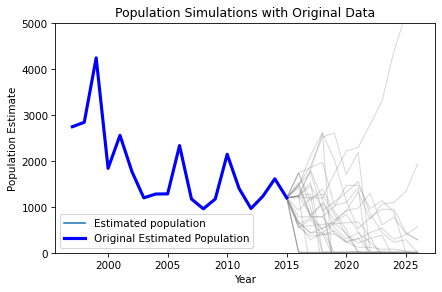

In [24]:
# Running the simulation 30 times
plot_many_simulations(system, update_func1, 30)

# Plotting the original population data to compare
plot_population(pop_series)

# original data with a bold blue line
pop_series.plot(label='Original Estimated Population', color='blue', linewidth=3)

decorate(xlabel='Year',
         ylabel='Population Estimate',
         title='Population Simulations with Original Data')

The results are highly variable: according to this model, the population might continue to decline over the next 10 years, or it might recover and grow rapidly!

It's hard to say how seriously we should take this model.  There are many factors that influence salmon populations that are not included in the model.  For example, if the population starts to grow quickly, it might be limited by resource limits, predators, or fishing.  If the population starts to fall, humans might restrict fishing and stock the river with farmed fish.

So these results should probably not be considered useful predictions.  However, there might be something useful we can do, which is to estimate the probability that the population will increase or decrease in the next 10 years.  

## Distribution of net changes

To describe the distribution of net changes, write a function called `run_many_simulations` that runs many simulations, saves the final populations in a `SweepSeries`, and returns the `SweepSeries`.

In [28]:
def run_many_simulations(system, update_func, iters):
    """
    Runs simulations and reports final populations.

    system: System object
    update_func: function object
    iters: number of simulations to run

    returns: SweepSeries of final populations
    """
    final_pops = SweepSeries()

    for i in range(iters):
        results = TimeSeries()
        results[system.t_0] = system.p_0

        for t in range(system.t_0 + 1, system.t_0 + system.duration + 1):
            results[t] = update_func(results[t-1], t, system)

        final_pops[i] = results[system.t_0 + system.duration]

    return final_pops

Test your function by running it with `iters=5`.

In [29]:
run_many_simulations(system, update_func1, 5)

Parameter
0      -0.044281
1    1873.886394
2    -223.917516
3      12.726925
4       5.814855
Name: Metric, dtype: float64

Now we can run 1000 simulations and describe the distribution of the results.

In [30]:
last_pops = run_many_simulations(system, update_func1, 1000)
last_pops.describe()

count     1000.000000
mean       242.516918
std        881.112743
min      -1887.591573
25%         -5.625706
50%          1.788532
75%        136.789484
max      10400.032872
Name: Metric, dtype: float64

If we substract off the initial population, we get the distribution of changes.

In [31]:
net_changes = last_pops - p_0
net_changes.describe()

count    1000.000000
mean     -958.483082
std       881.112743
min     -3088.591573
25%     -1206.625706
50%     -1199.211468
75%     -1064.210516
max      9199.032872
Name: Metric, dtype: float64

The median is negative, which indicates that the population decreases more often than it increases.

We can be more specific by counting the number of runs where `net_changes` is positive.

In [32]:
np.sum(net_changes > 0)

77

Or we can use `mean` to compute the fraction of runs where `net_changes` is positive.

In [33]:
np.mean(net_changes > 0)

0.077

And here's the fraction where it's negative.

In [34]:
np.mean(net_changes < 0)

0.923

So, based on observed past changes, this model predicts that the population is more likely to decrease than increase over the next 10 years, by about 2:1.

## A refined model

There are a few ways we could improve the model.

1.  It looks like there might be cyclic behavior in the past data, with a period of 4-5 years.  We could extend the model to include this effect.

2.  Older data might not be as relevant for prediction as newer data, so we could give more weight to newer data.

The second option is easier to implement, so let's try it.

I'll use `linspace` to create an array of "weights" for the observed rates.  The probability that I choose each rate will be proportional to these weights.

The weights have to add up to 1, so I divide through by the total.

In [35]:
weights = linspace(0, 1, len(rates))
weights /= sum(weights)
weights

array([0.        , 0.00653595, 0.0130719 , 0.01960784, 0.02614379,
       0.03267974, 0.03921569, 0.04575163, 0.05228758, 0.05882353,
       0.06535948, 0.07189542, 0.07843137, 0.08496732, 0.09150327,
       0.09803922, 0.10457516, 0.11111111])

I'll add the weights to the `System` object, since they are parameters of the model.

In [36]:
system.weights = weights

We can pass these weights as a parameter to `np.random.choice` (see the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html))

In [37]:
np.random.choice(system.rates, p=system.weights)

-0.5306267806267806

Write an update function that takes the weights into account.

In [43]:
# Solution goes here
def update_func_weighted(pop, t, system):
    """Update function that accounts for weights in selecting the growth rate.

    pop: current population
    t: current year
    system: system object with rates and weights

    returns: updated population
    """
    rate = np.random.choice(system.rates, p=system.weights)
    return pop + rate * pop

Use `plot_many_simulations` to plot the results.

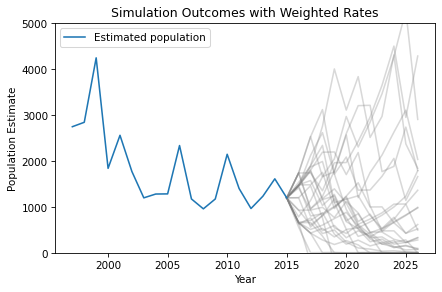

In [44]:
# Solution goes here
def plot_many_simulations(system, update_func, iters):
    """Runs simulations and plots the results for visual comparison.

    system: System object
    update_func: function object
    iters: number of simulations to run
    """
    for i in range(iters):
        results = run_simulation(system, update_func)
        results.plot(color='gray', label='_nolegend_', alpha=0.3)

    plot_population(pop_series)
    decorate(xlabel='Year', ylabel='Population Estimate', title='Simulation Outcomes with Weighted Rates')


plot_many_simulations(system, update_func_weighted, 30)

Use `run_many_simulations` to collect the results and `describe` to summarize the distribution of net changes.

In [45]:
# Solution goes here
def summarize_simulation_results(system, update_func, iters):
    """Collect results from multiple simulations and summarize the distribution of net changes.

    system: System object
    update_func: function object
    iters: number of simulations to run
    """
    results = run_many_simulations(system, update_func, iters)
    # Describe the results for an overview of distribution
    return results.describe()

summary_results = summarize_simulation_results(system, update_func_weighted, 100)
print(summary_results)

count     100.000000
mean      405.302838
std      1179.922009
min      -931.639253
25%         2.756604
50%        11.312392
75%       186.980690
max      7643.902122
Name: Metric, dtype: float64


Does the refined model have much effect on the probability of population decline?

In [46]:
# Solution goes here
def calculate_decline_probability(system, update_func, iters):
    """Calculate the probability of population decline over the simulation period.

    system: System object
    update_func: function object
    iters: number of simulations to run
    """
    results = run_many_simulations(system, update_func, iters)
    # Count how many of the final populations are less than the initial population
    declines = sum(result < system.p_0 for result in results)
    return declines / iters

decline_probability = calculate_decline_probability(system, update_func_weighted, 100)
print(f"Probability of population decline: {decline_probability * 100:.2f}%")

Probability of population decline: 89.00%
